In [82]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

np.set_printoptions(precision = 3)

In [177]:
def plot_matrix(matrix_seq, xAx, labels):
    true_neg = list(mat[0][0] for mat in matrix_seq)
    false_neg = list(mat[1][0] for mat in matrix_seq)
    false_pos = list(mat[0][1] for mat in matrix_seq)
    true_pos = list(mat[1][1] for mat in matrix_seq)
    #xAx = list(range(len(matrix_seq)))
    plt.plot(xAx, true_neg, color = 'red', label = 'TN')
    plt.plot(xAx, false_neg, color = 'blue', label = 'FN')
    plt.plot(xAx, true_pos, color = 'green', label = 'TP')
    plt.plot(xAx, false_pos, color = 'black', label = 'FP')
    plt.legend(loc='best')
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.grid(linewidth=1)
    plt.show()
    return 


def plot_scores(scores, param, labels):
    plt.plot(param, scores)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.grid(linewidth=1)
    plt.show()
    return

def plot_metrics(metrics, xAx, labels):
    marks = ['o','v','x','D']
    i = 0
    for key in metrics:
        plt.plot(xAx, metrics[key], label = key, marker = marks[i])
        i += 1
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.grid(linewidth = 1)
    plt.legend(loc='best')
    plt.show()
    return

def full_plot(mat, par, mat_lab):
        
#     plt.figure(figsize=(10,10))
#     plt.subplot(2,1,1)
#     plt.title("Confusion matrix")
#     plot_matrix(mat, par, mat_lab)
    
#     plt.figure(figsize = (10,10))
#     plt.subplot(2,1,1)
    
    plt.figure(figsize = (10,10))
    plt.subplot(2,1,1)
    plt.title("Positive metrics")
    metrics = get_metrics(mat, 'positive')
    best_scores = get_best_scores(metrics)
    plot_metrics(metrics, par, mat_lab)
    
    print_scores(best_scores)
    
    plt.figure(figsize = (10,10))
    plt.subplot(2,1,2)
    plt.title("Negative metrics")
    metrics = get_metrics(mat, 'negative')
    best_scores = get_best_scores(metrics)
    plot_metrics(metrics, par, mat_lab)
    
    print_scores(best_scores)
    return best_scores
    
def print_scores(scor):
    for key in scor:
        print(key, '\t\t-\t', "%.4f" % (scor[key]))
    return
    
def get_metrics(matrix_seq, cl):
    true_neg = np.asarray(list(mat[0][0] for mat in matrix_seq))
    false_neg = np.asarray(list(mat[1][0] for mat in matrix_seq))
    false_pos = np.asarray(list(mat[0][1] for mat in matrix_seq))
    true_pos = np.asarray(list(mat[1][1] for mat in matrix_seq))
    
    if cl == 'positive':
        accuracy = (true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)
        precision = true_pos/np.add(true_pos, false_pos)
        recall = true_pos/(true_pos + false_neg)
        FM = ((true_pos/(true_pos + false_pos))*(true_pos/(true_pos+false_neg)))**(1/2)
        F1score = 2*precision*recall/(precision+recall)
    elif cl == 'negative':
        accuracy = (true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)
        precision = true_neg/np.add(true_neg, false_neg)
        recall = true_neg/(true_neg + false_pos)
        FM = ((true_pos/(true_pos + false_pos))*(true_pos/(true_pos+false_neg)))**(1/2)
        F1score = 2*precision*recall/(precision+recall)
        
    metr = dict()
    metr['Recall'] = recall
    metr['Precision'] = precision
#     metr['F1 score'] = F1score
#     metr['Folwkes-Mallows'] = FM
    metr['Accuracy'] = accuracy
    return metr

def get_best_scores(metr):
    best_sc = dict()
    for key in metr:
        best_sc[key] = np.max(metr[key])
    return best_sc

In [108]:
df = pd.read_csv('total_data_mining_vid.csv')

In [110]:
df = df.drop('contact_freq', 1)
df.head()

,Name,central_freq,central_freq_amp,peak_count,peak_mean,peak_SD,peak_matters_SD,peak_matters_Int,dixi,signal_peaks,sig_mean,sig_SD,target
0,marina1_0_Con,1.269531,0.024937,6,0.009430,0.005487,2.826011,0.019358,6.352830e-16,11,0.797182,0.100137,0
1,marina1_1_Con,1.269531,0.025100,6,0.009473,0.005534,2.823573,0.019494,5.587141e-01,12,0.797405,0.099999,1
2,marina1_2_Con,1.269531,0.025121,6,0.009466,0.005525,2.833311,0.019513,1.555379e-16,12,0.797461,0.099981,1
3,marina1_3_Con,1.269531,0.025122,6,0.009410,0.005496,2.858880,0.019503,1.567477e-16,12,0.797321,0.100062,1
4,marina1_4_Con,1.269531,0.025625,5,0.009436,0.005772,2.804777,0.019717,4.358380e-16,12,0.796177,0.102167,1


df = df.drop('contact_freq', 1)
df.head()

In [111]:
nulls = df[df['target']==0].count()
nulls = nulls['Name']
ones = df[df['target']==1].count()
ones = ones['Name']

lenDiff = abs(nulls-ones)
halfLength = int(ones/2)
print(halfLength)

2654


In [112]:
df_null = df[df['target']==0].iloc[lenDiff:]
df_ed = df[df['target']==1]
df_train = pd.concat([df_null.head(halfLength), df_ed.head(halfLength)], ignore_index = True)
df_ver = pd.concat([df_null.tail(halfLength), df_ed.tail(halfLength)], ignore_index = True)

df_train.sample(frac=1).reset_index(drop=True)
df_ver.sample(frac=1).reset_index(drop=True)

,Name,central_freq,central_freq_amp,peak_count,peak_mean,peak_SD,peak_matters_SD,peak_matters_Int,dixi,signal_peaks,sig_mean,sig_SD,target
0,Nazarova_2_622_Vid,1.269531,0.068846,6,0.014354,0.011867,4.591775,0.036466,2.164091e-16,13,0.461073,0.219800,1
1,semchuk5_prised_611_Vid,1.464844,0.048055,7,0.013265,0.013585,2.560895,0.027524,1.955572e-01,13,0.595879,0.194570,0
2,semchuk5_prised_517_Vid,1.464844,0.037789,8,0.012855,0.020795,1.198995,0.023325,3.207743e-01,14,0.654295,0.178980,0
3,Omel_2_705_Vid,0.878906,0.093147,8,0.089488,0.007354,0.497579,0.033245,5.886015e-02,15,0.073808,0.078371,0
4,Omel_2_420_Con,0.585938,0.055111,10,0.011007,0.016471,2.677661,0.028667,4.202581e-01,14,0.599445,0.243770,0
5,Omel_2_273_Con,0.878906,0.012957,9,0.002888,0.004605,2.186362,0.010297,4.445627e-02,13,0.837334,0.090268,0
6,Omel_2_260_Vid,0.878906,0.061136,7,0.046366,0.028968,0.509872,0.026522,3.190727e-16,14,0.152566,0.093870,0
7,new_semcha_0_52_Vid,1.367188,0.046606,7,0.016805,0.022678,1.314058,0.024384,1.511129e-01,13,0.617406,0.212631,1
8,Nazarova_2_222_Con,1.269531,0.042885,9,0.006326,0.008251,4.430724,0.027874,3.134555e-01,13,0.766076,0.170105,1
9,semchuk5_prised_461_Con,0.878906,0.043511,6,0.018098,0.010170,2.498754,0.021468,1.727850e-15,13,0.455483,0.224791,0


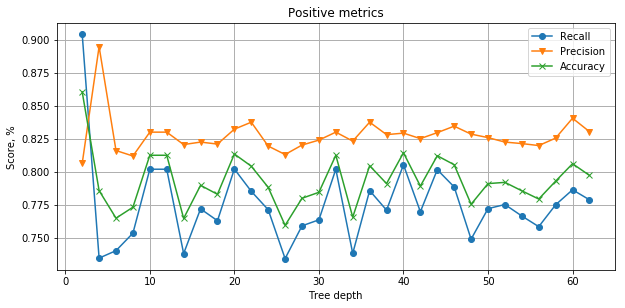

Recall 		-	 0.9045
Precision 		-	 0.8949
Accuracy 		-	 0.8606


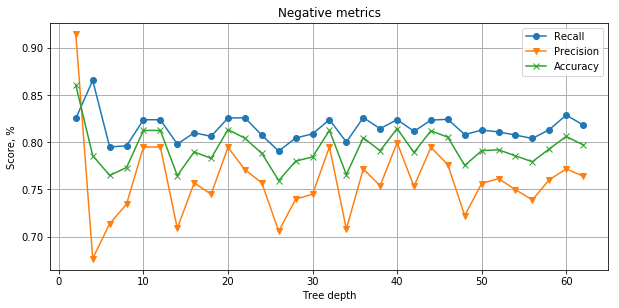

Recall 		-	 0.8655
Precision 		-	 0.9148
Accuracy 		-	 0.8606


In [178]:
features = ['central_freq', 'central_freq_amp', 'peak_count', 'peak_SD', 'peak_matters_SD', 'peak_matters_Int','sig_SD','sig_mean', 'dixi', 'signal_peaks']
scores = []
conf_mat = []
deps = []

for i in range(2,64, 2):    
    age_sal_tree = DecisionTreeClassifier(criterion='entropy', max_depth=i, max_features = len(features), random_state=None)
    age_sal_tree.fit(df_train[features].values, df_train['target'].values)
    scoreRes = age_sal_tree.score(df_ver[features].values, df_ver['target'].values)
    res_pred = age_sal_tree.predict(df_ver[features].values)
    scores.append(scoreRes*100)
    conf_mat.append(100*confusion_matrix(res_pred, df_ver['target'].values)/halfLength)
    deps.append(i)
    
full_plot(conf_mat, deps, ['Tree depth', 'Score, %'])

export_graphviz(age_sal_tree, out_file='tree.dot', precision=5)


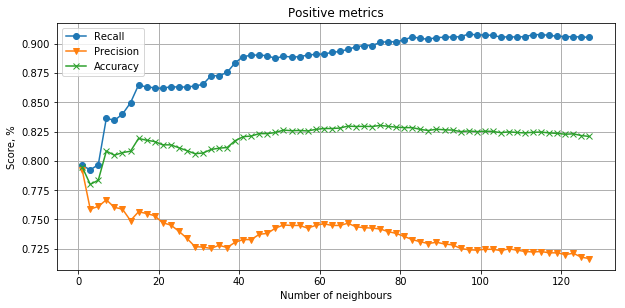

Recall 		-	 0.9083
Precision 		-	 0.7924
Accuracy 		-	 0.8303


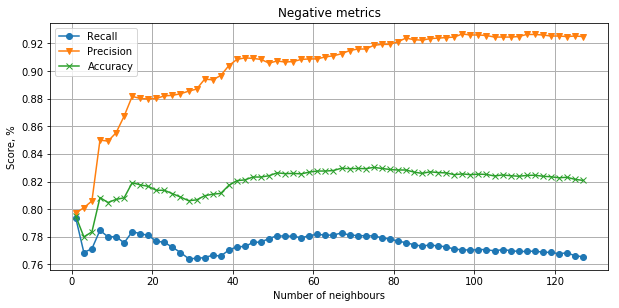

Recall 		-	 0.7934
Precision 		-	 0.9269
Accuracy 		-	 0.8303


{'Accuracy': 0.8302562170308968,
 'Precision': 0.92690278824415973,
 'Recall': 0.7934008248968879}

In [179]:
neis = []
scores = []
conf_mat = []
for i in range(1,128, 2):
    nei = KNeighborsClassifier(n_neighbors=i)
    nei.fit(df_train[features].values, df_train['target'].values)
    scoreRes = nei.score(df_ver[features].values, df_ver['target'].values)
    neis.append(i)
    scores.append(scoreRes*100)
    res_pred = nei.predict(df_ver[features].values)
    conf_mat.append(100*confusion_matrix(res_pred, df_ver['target'].values)/halfLength)

full_plot(conf_mat, neis, ["Number of neighbours", "Score, %"])

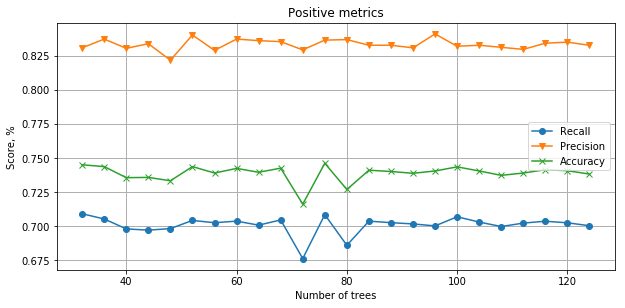

Recall 		-	 0.7092
Precision 		-	 0.8410
Accuracy 		-	 0.7462


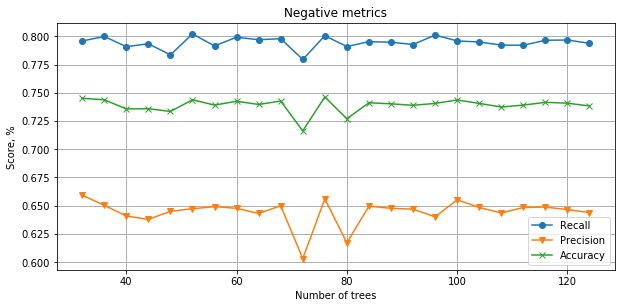

Recall 		-	 0.8021
Precision 		-	 0.6594
Accuracy 		-	 0.7462


{'Accuracy': 0.74623210248681238,
 'Precision': 0.65938206480783723,
 'Recall': 0.8020541549953315}

In [181]:
# The official page of the algorithm states that random forest does not overfit,
# and you can use as much trees as you want. But Mark R. Segal 
# (April 14 2004. "Machine Learning Benchmarks and Random Forest Regression."
#  Center for Bioinformatics & Molecular Biostatistics) has found that it overfits
# for some noisy datasets. So to obtain optimal number you can try training random 
# forest at a grid of ntree parameter (simple, but more CPU-consuming) or build one 
# random forest with many trees with keep.inbag, calculate out-of-bag (OOB) error rates
# for first nn trees (where nn changes from 11 to ntree) and plot OOB error rate vs. 
# number of trees (more complex, but less CPU-consuming).

scores = []
estims = []
conf_mat = []

for i in range(32, 128, 4):    
    fore = RandomForestClassifier(n_estimators = i, max_features = len(features), random_state=None)
    fore.fit(df_train[features].values, df_train['target'].values)
    scoreRes = fore.score(df_ver[features].values, df_ver['target'].values)
    res_pred = fore.predict(df_ver[features].values)
#     print(age_sal_tree.feature_importances_)
    scores.append(scoreRes)
    conf_mat.append(confusion_matrix(res_pred, df_ver['target'].values)/halfLength)
    estims.append(i)
full_plot(conf_mat, estims, ["Number of trees", "Score, %"])


/home/ivan7chuk/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/ivan7chuk/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/home/ivan7chuk/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:421: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)


newton-cg


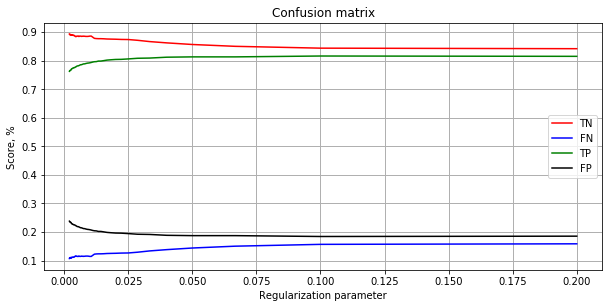

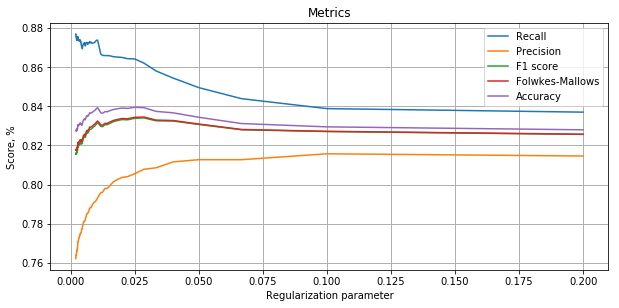

lbfgs


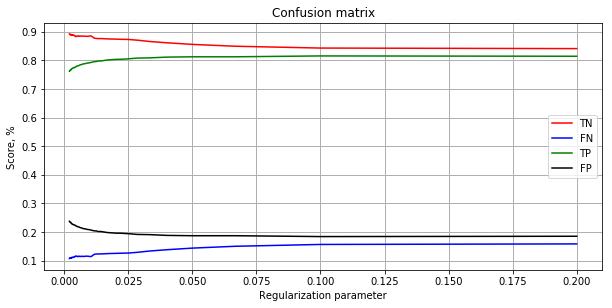

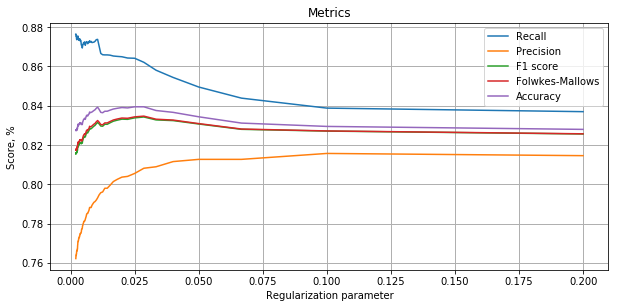

liblinear


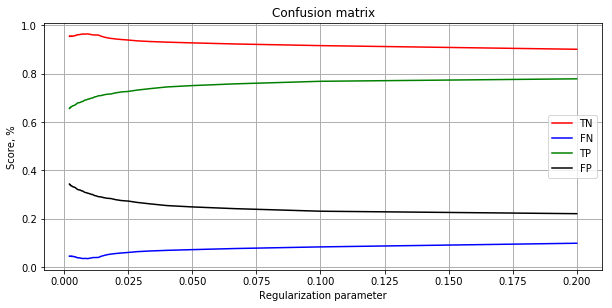

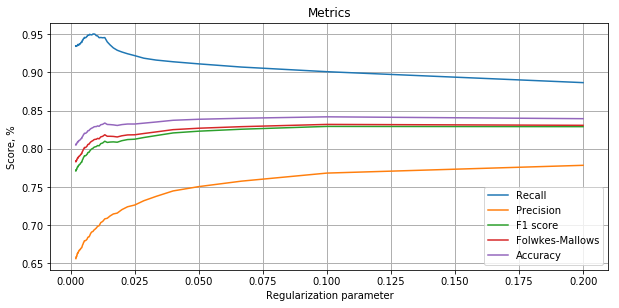

/home/ivan7chuk/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


sag


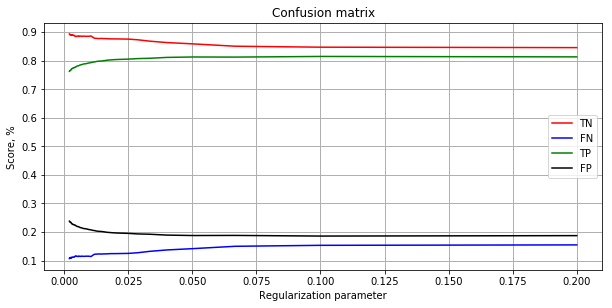

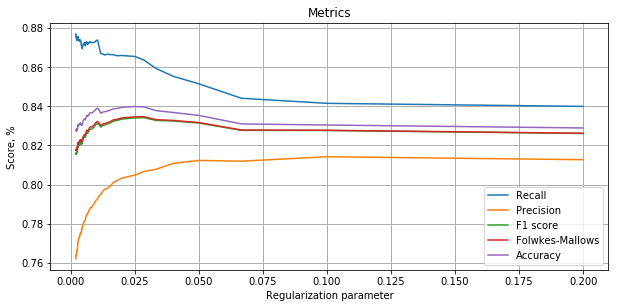

saga


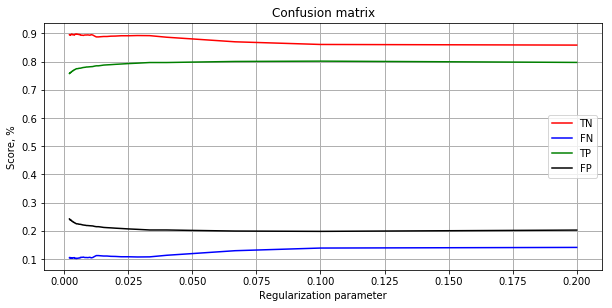

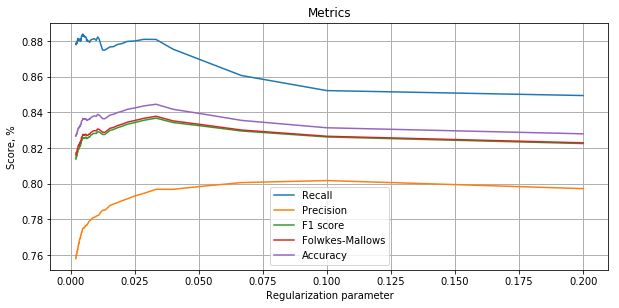

In [148]:
lin_clf = linear_model.LogisticRegression()
penalties = ['l1','l2']

lin_clf.tol = 0.000001 
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for sol in solvers:
    lin_clf.solver = sol
    scores = []
    alphas = []
    conf_mat = []
    for i in range(10, 1000, 10):
        a = 2/i
        lin_clf.C = a
        lin_clf.fit(df_train[features].values, df_train['target'].values)
        scoreRes = lin_clf.score(df_ver[features].values, df_ver['target'].values)
        res_pred = lin_clf.predict(df_ver[features].values)
        scores.append(scoreRes)
        conf_mat.append(confusion_matrix(res_pred, df_ver['target'].values)/halfLength)
        alphas.append(a)
    print(sol)
    full_plot(conf_mat, alphas, ["Regularization parameter", 'Score, %'])
    plt.show()